# Lab #3: Asking a statistical question
This week we are going to concentrate on asking a statistical question. This process always consists of two steps:

1. Writing down in words very precisely what question you are trying to ask.
2. Converting the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and the to integral to do to obtain a probability.

So in this lab we will assume that we know the form of the signal-free background distribution (determining a distribution from data will be next week's lab). In each of our three examples, your task will be to state the statistical question, convert it to math, then perform the associated analyses.

## Problem 1
In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

To make this a bit concrete, we will simulate a little data. Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

### A)  So our goal is to identify bad data and throw it out.

#### Start by exploring the data you have created with appropriate plots

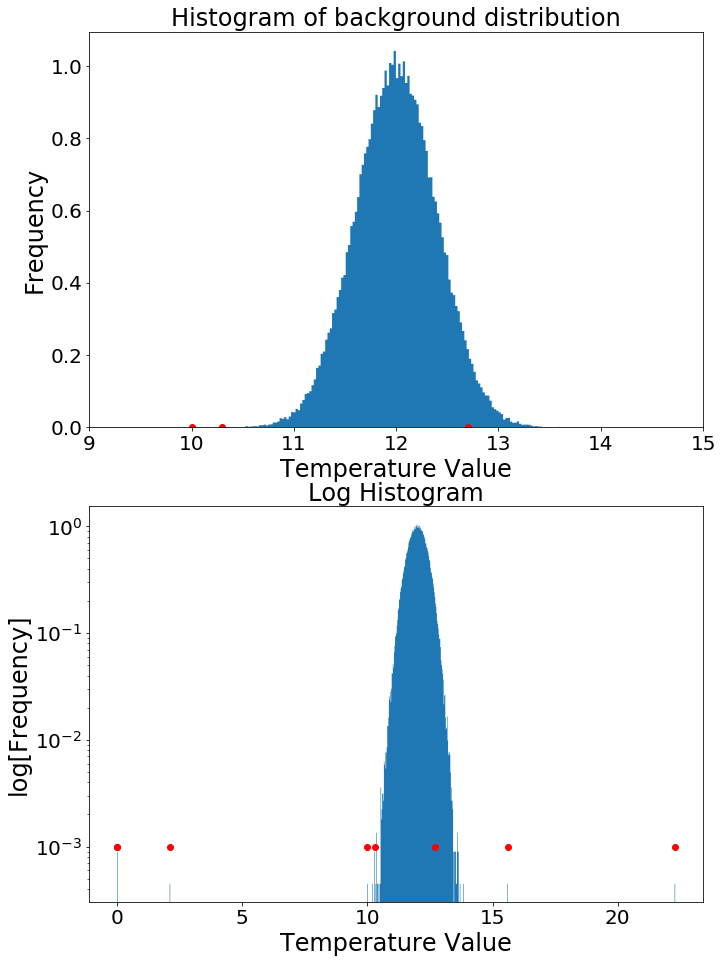

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import math
from scipy.optimize import curve_fit
from scipy import stats
from matplotlib.patches import Polygon

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(11,16)

bad_data = [10, 10.3, 2.1, 0, 0, 15.6, 22.3, 12.7]
mean = 12
std = 0.4
distribution = stats.norm.rvs(loc=mean, scale=std, size=100000)
distribution = np.append(distribution, bad_data)
hist = ax[0].hist(distribution, bins = 1000, density=True, histtype='stepfilled')
ax[0].set_title("Histogram of background distribution", fontsize=24)
ax[0].set_xlabel("Temperature Value", fontsize=24)
ax[0].set_ylabel("Frequency", fontsize=24)
ax[0].tick_params(labelsize=20)
axis = ax[0].set_xlim([9,15])

ax[1].set_title("Log Histogram", fontsize=24)
ax[1].set_yscale("log")
ax[1].set_xlabel("Temperature Value", fontsize=24)
ax[1].set_ylabel("log[Frequency]", fontsize=24)
ax[1].tick_params(labelsize=20)

for point in bad_data:
    ax[0].plot(point, 0, 'ro')
    ax[1].plot(point, 0.001, 'ro')

hist = ax[1].hist(distribution, bins = 1000, density=True, histtype='stepfilled')

#### State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.  
  
According to the 68-95-99.7, 99.7% of our data should live within 3 standard deviations of the mean.  Too be extra safe, we can go another standard deviation and we should still retain 99.999% of valid data.  The statistical question is therefore, "Which data points are not within four standard deviations of the mean?"  

#### Restate your question in math. Be very clear.
In order to accomplish this, we need to iterate through our distribution and discard any values that are outside of this range.

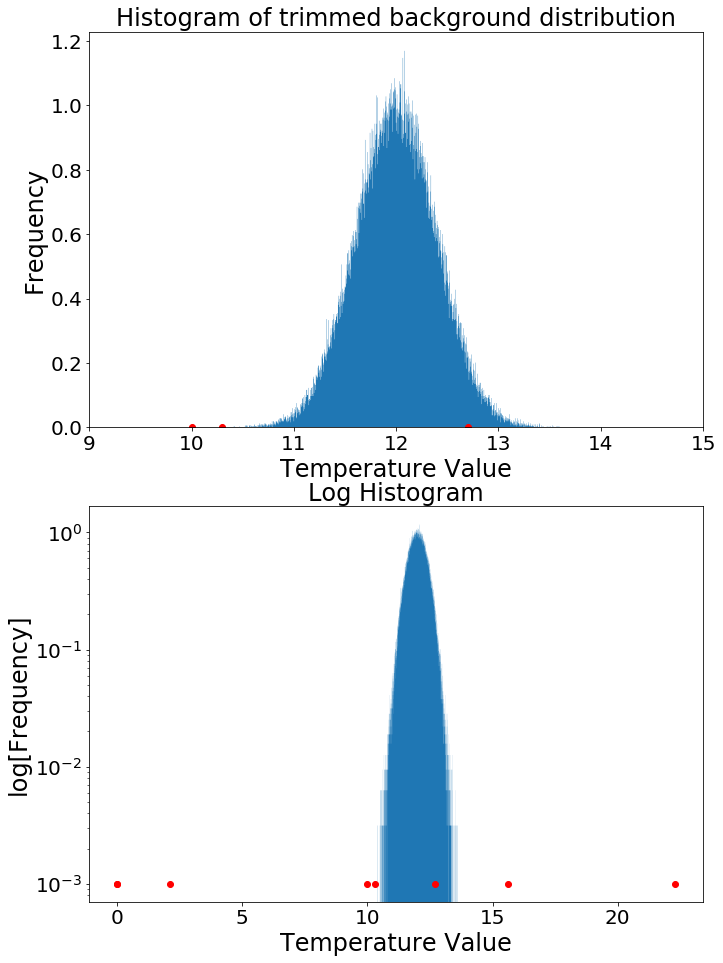

In [3]:
# This function tells us if a number is not in our distribution.  Z is the sigma value to check for outliers.
# returns true if the point is not an outlier, false otherwise
def isNotOutlier(value, z):
    return value > (mean - z*std) and value < (mean + z*std)

z = 4
trimmedData = []

for value in distribution:
        if isNotOutlier(value, z):
            trimmedData.append(value)
            
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(11,16)

hist = ax[0].hist(trimmedData, bins = 1000, density=True, histtype='stepfilled')
ax[0].set_title("Histogram of trimmed background distribution", fontsize=24)
ax[0].set_xlabel("Temperature Value", fontsize=24)
ax[0].set_ylabel("Frequency", fontsize=24)
ax[0].tick_params(labelsize=20)
axis = ax[0].set_xlim([9,15])

ax[1].set_title("Log Histogram", fontsize=24)
ax[1].set_yscale("log")
ax[1].set_xlabel("Temperature Value", fontsize=24)
ax[1].set_ylabel("log[Frequency]", fontsize=24)
ax[1].tick_params(labelsize=20)

for point in bad_data:
    ax[1].plot(point, 0.001, 'ro')
    ax[0].plot(point, 0, 'ro')

hist = ax[1].hist(trimmedData, bins = 1000, density=True, histtype='stepfilled')

#### Apply your statistical test and construct a truth table

The execution of the test is above, the truth table will be below.  Positive results are defined as data points that our test say are outliers, negative results are not outliers.  True results are if the data point actually fell in the catagory that my test put it in and false results are incorrectly identified.  The goal is to minimize the number of false results.

In [4]:
from tabulate import tabulate

def truthTable(distribution, z):
    falsePos, truePos, falseNeg, trueNeg = [0,0,0,0]

    # ideally, we want 100000 true negatives and 9 true positives.
    # this is because there are 9 outliers and 100000 good data points.
    for value in distribution:
        if isNotOutlier(value, z):
            # if our test says it isn't an outlier, it is a negative result
            if bad_data.count(value) > 0:
                # if it is in bad_data, this is a false negative
                falseNeg += 1
            else:
                # if it is not in bad_data, this is a true negative
                trueNeg += 1
        else:
            # if it is an outlier, this is a positive result
            if bad_data.count(value) > 0:
                # if it is in bad_data, this is a true positive
                truePos += 1
            else:
                # if it is not in bad_Data, this is a false positive
                falsePos += 1

    print(tabulate([['Pos',truePos,falsePos],['Neg',trueNeg,falseNeg]],headers=['','True','False']))
    
truthTable(distribution, z)

       True    False
---  ------  -------
Pos       7       12
Neg   99988        1


The idea is how often you kept the known good data (True Pos), how often you correctly discarded bad data (False Neg), and how often mistakes were made of either omission or commission (True Neg, & False Pos).

### B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

As acknowledged in my discussion about my statistical question above, we can use the 68-95-99.7 rule (or alternatively integrate the standard normal distribution between the cutoff that you choose) to predict how much of our good data will end up being discarded.  Using $4\sigma$, we correctly identified 99,9988 out of 100,000 valid data points for a correct ID rate of 99.999%, which is exaclty our predicted value.

### C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

Using my test, only 1 of the 8 bad data points were committed to my final data set.  Because we don't know how the bad data is disttributed, it is not possible to be able to predict how good a given test will be at identifying bad data.

## Problem 2
In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

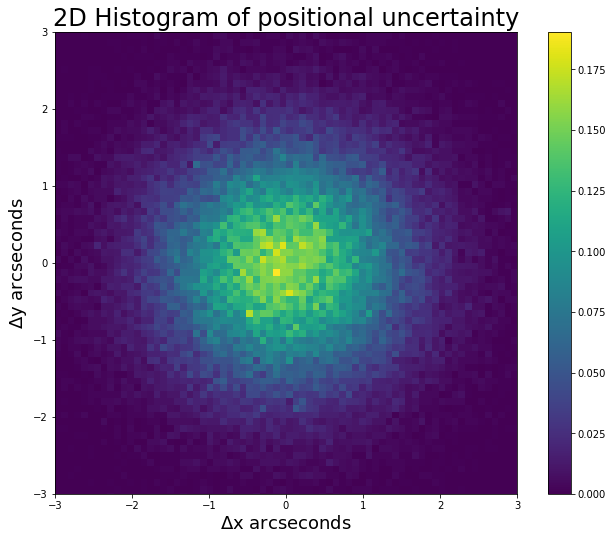

In [5]:
#a = np.concatenate(np.array(stats.norm.rvs( scale = 1, size = 100000)), np.array(stats.norm.rvs( scale = 1, size = 100000)), axis = 1)
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(11,8.5)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

### What is the question in words?

Because the background distribution is defined by how far stars move between consecutive pictures, we would expect an asteroid to move much more than a star since it is so much closer.  The distance moved by an object is $\sqrt{(\Delta x)^2 + (\Delta y)^2}$.  If our distribution has some $\sigma$, a potential asteroid will have moved at least $5\sigma$ between photographs.  Our statistical question is, "What is the minimum threshold movement required to have $5\sigma$ detection?"

### What is the question in math?

We are given that the background distribution for both the x and y directions are standard normal distributions, i.e., the mean is 0 and the $\sigma$ is 1.  This means that our pdf is defined as $f(x, y) = A\cdot e^{-(\frac{x^2}{2} + \frac{y^2}{2})}$ where A is a normalization coefficient.  However, we only care about the distance that is moved, not the actual direction, so we can define a length vector $r = \sqrt{x^2 + y^2}$ and we end up with $f(r) = A\cdot e^{-\frac{r^2}{2}}$.  This is the form of the standard normal distribution.  However, this function is only defined for $r > 0$, so in order to find our normalization component, we must solve for $A$ in: $A \cdot \int_0^\infty e^{-\frac{r^2}{2}}dr = 1$.  Using a Gaussian integral table, we can find that this coefficient is therefore $\sqrt{\frac{2}{\pi}}$.  Finally, this means that our PDF is: $f(r) = \sqrt{\frac{2}{\pi}}e^{-\frac{r^2}{2}}$.  As it turns out, this is a half-normal distribution.  $5\sigma$ is defined as 1 in 3.5 million, so we need to figure out where this falls in our distribution, thus we are solving for some $z$ such that: $\int_0^z f(r) dr = \frac{1}{3.5 \cdot 10^6} $.  The $z$ that we end up with will be the minimum distance traveled for a potential asteroid to be significant.

## Problem 3

As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

As always:

### What is the question in words?

Because our question is about the number of occurences of an event within a given time frame and the arrival events are independant of another, we are going to have a Poisson distribution.  The problem tells us that we normally see 1 cosmic ray per minute, so our Poisson is characterized by $\mu=1$.  Because we expect the moon to block some rays, more signal like is fewer rays arriving from this region.  The question is, given this Poisson distribution, is detecting 6800 rays in 7200 minutes significant?

### Translate the question to math, describing both the expected background pdf() and the integral you need to do.

The PDF for a Poisson distribution is $\frac{\lambda^k e^{-\lambda}}{k!}$ where $\lambda$ is our rate parameter (1 cosmic ray per minute in our case) and $k$ is the number of events in the interval.  Because we are summing this over 7200 minutes, we can change our rate parameter to 7200.  Using this, our math becomes $\sum_{k=0}^{6800} \frac{7200^k e^{-7200}}{k!} = P$.  If $P$ is greater than $\frac{1}{3,500,000}$, then it is not significant.

### Convert to sigma.

In [29]:
prob = stats.poisson.cdf(6800, mu=7200,loc=0)
sigma = stats.norm.ppf(prob, scale=1, loc=0)

print(sigma)

-4.750747965777188


Our sigma is not better than 5, so the shadow is not significant.